In [1]:
from __future__ import division

In [2]:
%matplotlib inline

#### libraries and functions

In [3]:
import gdist
import numpy as np
import pandas as pd
#from pqdict import PQDict
#from mayavi import mlab
import seaborn as sns
from scipy import stats as stats
import scipy as sp
import matplotlib.pyplot as plt
from vtk_rw import read_vtk, write_vtk
from graphs import graph_from_mesh
from plotting import plot_surf_stat_map

In [4]:
def dijkstra(G, start, end=None):
    '''
    dijkstra's algorithm determines the length from `start` to every other 
    vertex in the graph.
    The graph argument `G` should be a dict indexed by nodes.  The value 
    of each item `G[v]` should also a dict indexed by successor nodes.
    In other words, for any node `v`, `G[v]` is itself a dict, indexed 
    by the successors of `v`.  For any directed edge `v -> w`, `G[v][w]` 
    is the length of the edge from `v` to `w`.
        graph = {'a': {'b': 1}, 
                 'b': {'c': 2, 'b': 5}, 
                 'c': {'d': 1},
                 'd': {}}
    Returns two dicts, `dist` and `pred`:
        dist, pred = dijkstra(graph, start='a') 
    
    `dist` is a dict mapping each node to its shortest distance from the
    specified starting node:
        assert dist == {'a': 0, 'c': 3, 'b': 1, 'd': 4}
    `pred` is a dict mapping each node to its predecessor node on the
    shortest path from the specified starting node:
        assert pred == {'b': 'a', 'c': 'b', 'd': 'c'}
    
    '''
    inf = float('inf')
    D = {start: 0}          # mapping of nodes to their dist from start
    Q = PQDict(D)           # priority queue for tracking min shortest path
    P = {}                  # mapping of nodes to their direct predecessors
    #U = set(G.keys())       # unexplored nodes
    U = set(G.nodes())

    while U:                                    # nodes yet to explore
        (v, d) = Q.popitem()                    # node w/ min dist d on frontier
        D[v] = d                                # est dijkstra greedy score
        U.remove(v)                             # remove from unexplored
        if v == end: break

        # now consider the edges from v with an unexplored head -
        # we may need to update the dist of unexplored successors 
        for w in G[v]:                          # successors to v
            if w in U:                          # then w is a frontier node
                d = D[v] + G[v][w]              # dgs: dist of start -> v -> w
                if d < Q.get(w, inf):
                    Q[w] = d                    # set/update dgs
                    P[w] = v                    # set/update predecessor

    return D, P

In [5]:
def shortest_path(G, start, end):
    dist, pred = dijkstra(G, start, end)
    v = end
    path = [v]
    while v != start:
        v = pred[v]
        path.append(v)        
    path.reverse()
    return path

### Read and convert data

In [6]:
#mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_rh_d.vtk'
mesh_file = '/SCR/data/ohbm2016/lowres_rh_d.vtk'
sulc_file = '/SCR/data/ohbm2016/lowres_rh_sulc.npy'
embed_file = '/SCR/data/ohbm2016/mask_025_5/rh_embed_10.npy'
t1_file = '/SCR/data/ohbm2016/avg_rh_profiles.npy'

In [7]:
v,f,d=read_vtk(mesh_file)
vertices = v.astype(np.float64)
faces = f.astype(np.int32)
sulc = np.load(sulc_file)
profiles = np.load(t1_file)
embed = np.load(embed_file)

In [8]:
G=graph_from_mesh(vertices, faces, edge_length=True)

### Create path and windows

The graph representation of the surface is used to find the shortest path between the chosen source and target node. For each node on the path a window is created containing all other nodes that lie within a given radius and are closer to this node that to any other node on the path. These single node windows are then combined into a larger window with the chosen width that is sliding along the path (for now with step=1 node).

In [9]:
radius=5
width=3
source=46644
target=59276

In [10]:
#path=shortest_path(G,source,target)
path=list(np.load('/SCR/data/ohbm2016/rh_4664_59276.npy'))
#np.save('/scr/ilz3/myelinconnect/all_data_on_simple_surf/path/rh_4664_59276.npy', np.asarray(path))

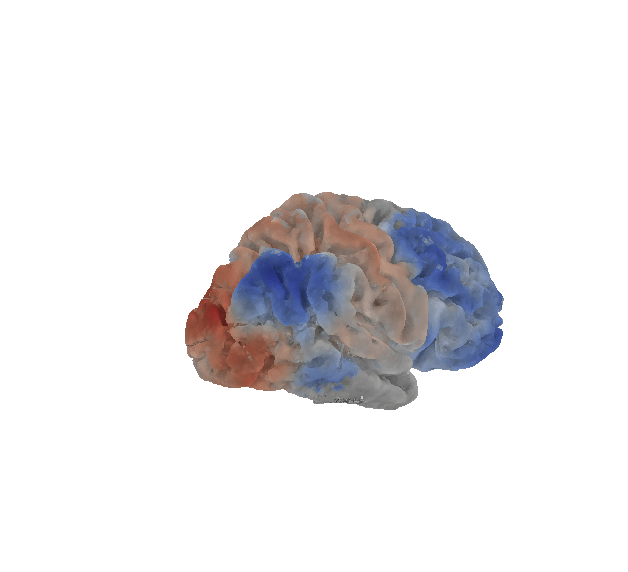

In [44]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=embed[:,0],
                        bg_map=sulc, bg_on_stat=True, 
                        elev=200,azim=20, figsize=(11,10))

In [60]:
source_target = np.zeros_like(embed[:,0])
source_target[np.where(embed[:,0]-np.min(embed[:,0])<0.005)]=1
source_target[np.where(np.max(embed[:,0])-embed[:,0]<0.005)]=-1

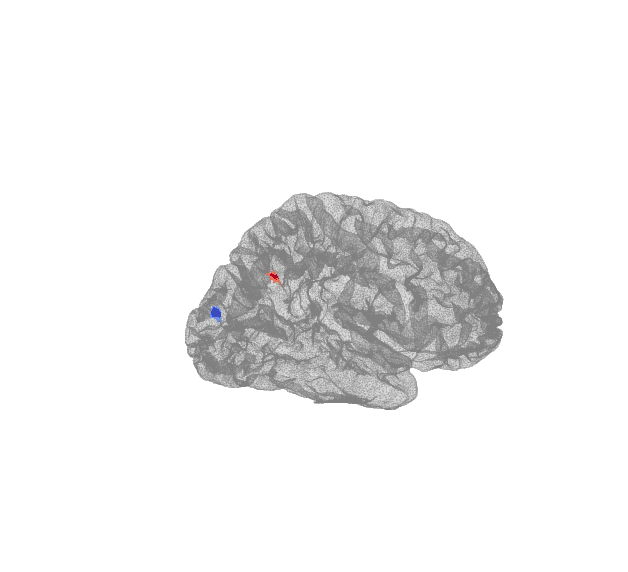

In [61]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=source_target,
                        threshold=0.5, alpha=0.1, 
                        elev=200,azim=20, figsize=(11,10))

In [11]:
pathbrain = np.zeros_like(vertices[:,0])
pathbrain[path] = 1

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


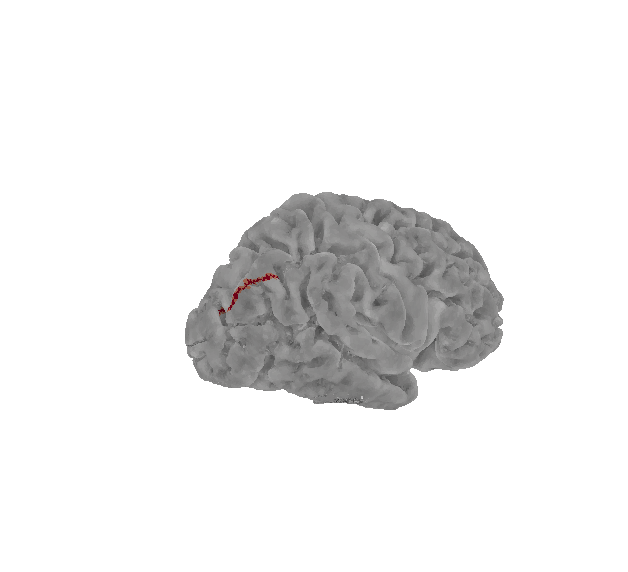

In [12]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=pathbrain, bg_map=sulc, bg_on_stat=True, elev=200,azim=20, figsize=(11,10))

In [13]:
# for each vertex show only those vertices in the sparse matrix, that have a distance < radius
# for these give the precise distance
inradius_matrix=gdist.local_gdist_matrix(vertices, faces, max_distance=radius)

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [14]:
# get only the vertices that are in a distance < radius to any node in path
inradius_path=[]
for pnode in path:
    inradius_path=list(np.unique(inradius_matrix[:,path].indices))

In [15]:
# make an array with the radius neighbours in columns and the path nodes in rows
path_x_neighbours=np.zeros((len(inradius_path), len(path)))
for pnode in range(len(path)):
    path_x_neighbours[:,pnode]=np.reshape(inradius_matrix[inradius_path,path[pnode]].toarray(),
                                          (len(inradius_path),))
path_x_neighbours[path_x_neighbours==0]=np.nan

In [16]:
# for each vertex in this list, find the node on path it is closest to
path_x_neighbours_min=np.zeros((len(inradius_path),1))
for nnode in range(len(inradius_path)):
    path_x_neighbours_min[nnode]=np.nanargmin(path_x_neighbours[nnode,:])

In [17]:
#for each node on the path, extract those neighbour nodes, that fall into its window
windows=[]
for pnode in range(len(path)):
    window=[path[pnode]]
    indices = [i for i, x in enumerate(list(path_x_neighbours_min)) if x == pnode]
    [window.append(inradius_path[y]) for y in indices]
    windows.append(window)

In [18]:
# combine single windows for sliding
combined_windows=[]
for window in range(len(windows)):
    combined_window=[]
    for k in range((window-width),(window+width)):
        if (k>=0) and (k<=len(windows)-1):
            combined_window+=windows[k]
    combined_windows.append(combined_window)
    
#np.save('/SCR/data/ohbm2016/rh_4664_59276_rad10_w3_windows.npy', combined_windows)

Get windows back to surface space

In [19]:
# construct a full surface for each window, with only the window nodes set to 1
window_surfs=[]
for combined_window in range(len(combined_windows)):
    window_surf=np.zeros((len(vertices),))

    for j in path:
        window_surf[j]=1
        
    for i in combined_windows[combined_window]:
        window_surf[i]=100
    window_surfs.append(window_surf)

In [20]:
# construct single surface with all windows differently carrying a different number
allwindow_surf=np.zeros((len(vertices),))
for window in range(len(windows)):
        
    for i in windows[window]:
        allwindow_surf[i]=window+2

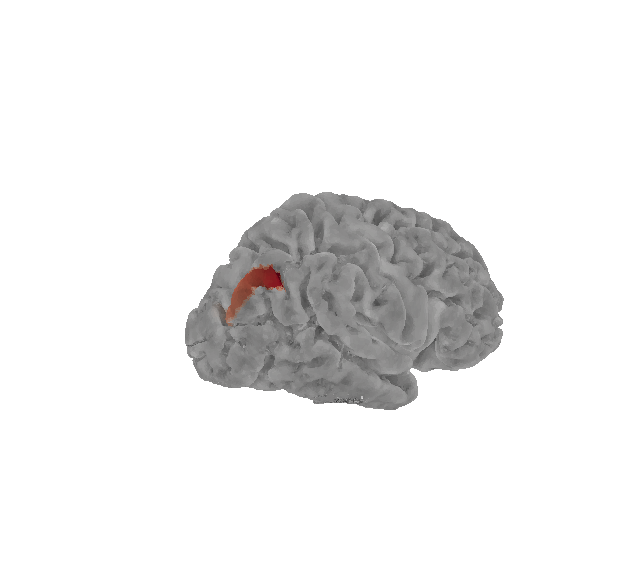

In [21]:
sns.set_style('white')
plot=plot_surf_stat_map(vertices, faces, stat_map=allwindow_surf, bg_map=sulc, bg_on_stat=True, 
                        elev=200,azim=20, figsize=(11,10))

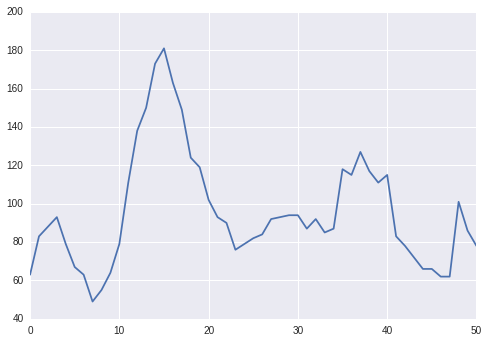

In [22]:
wsize=[]
for window in combined_windows:
    wsize.append(len(window))
sns.set_style('darkgrid')
plt.plot(wsize)
sns.axlabel=('Window', '# Vertices')

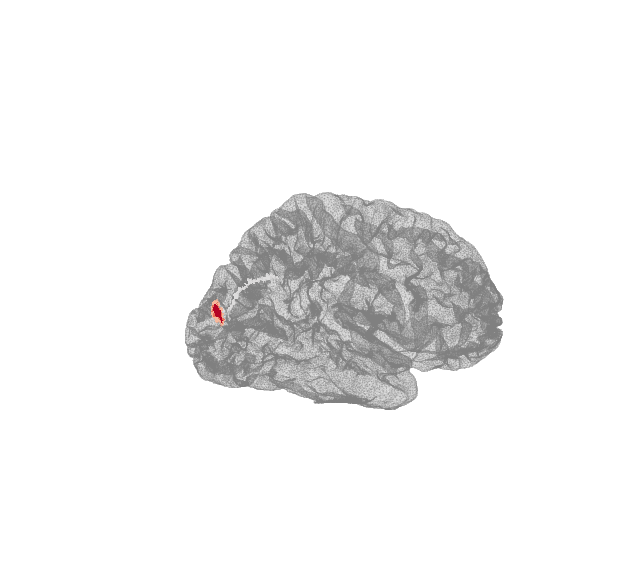

In [27]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[0], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

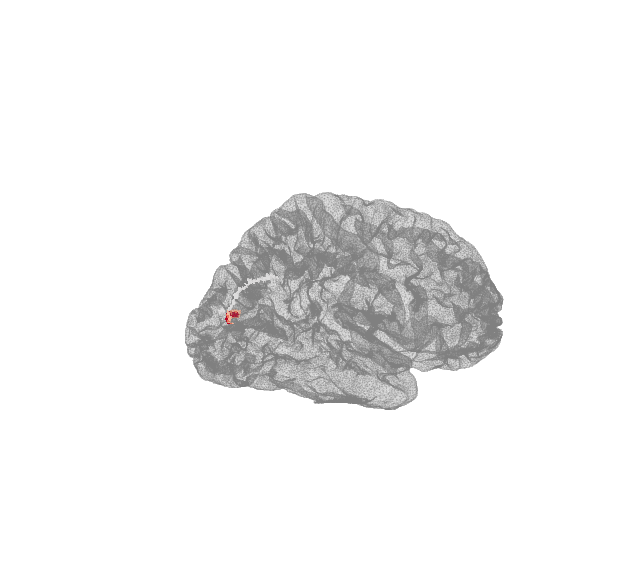

In [29]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[20], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

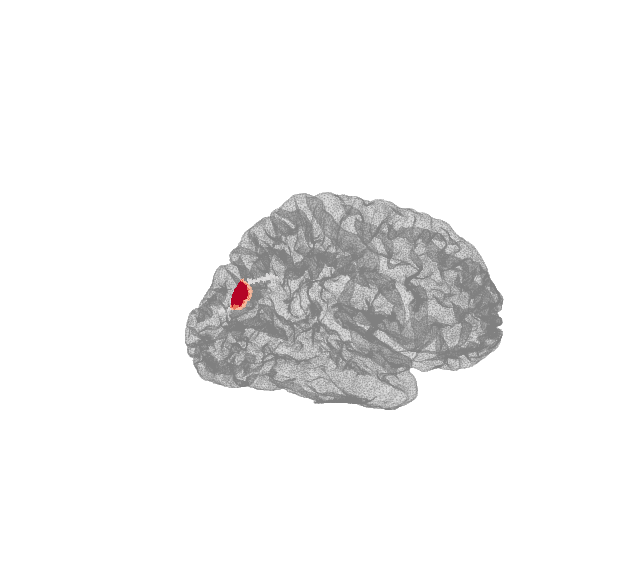

In [32]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[30], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

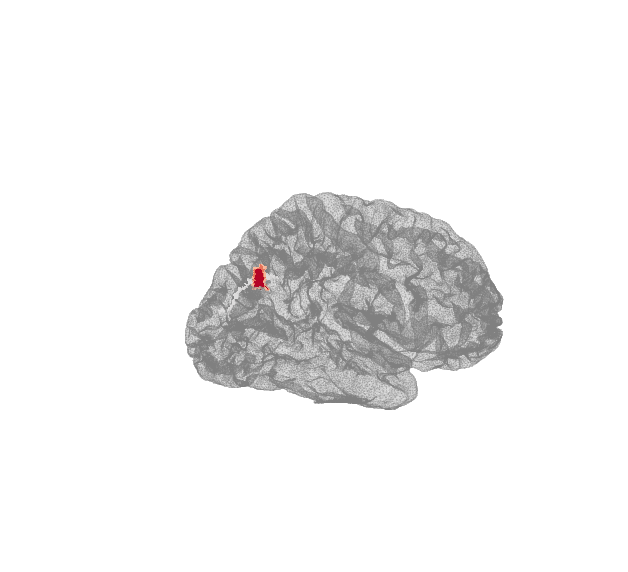

In [30]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[40], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

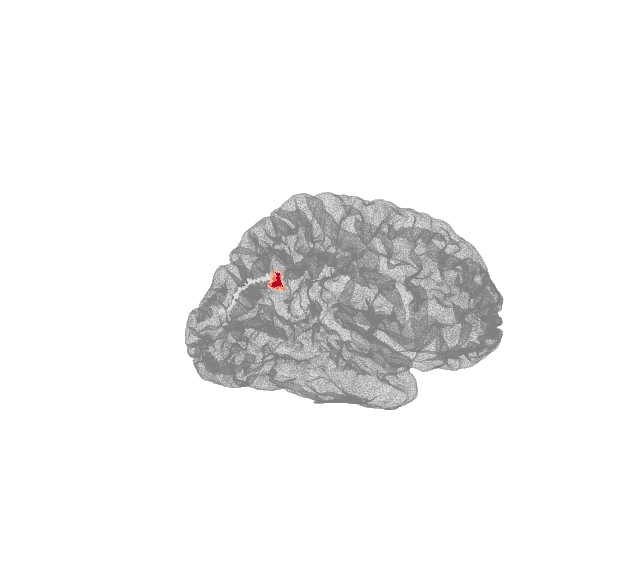

In [31]:
sns.set_style('white')
surf_1 = plot_surf_stat_map(vertices, faces, stat_map=window_surfs[-1], elev=200, azim=20, 
                            threshold=0.5, alpha=0.1, 
                            #cmap='Spectral', 
                            figsize=(11,10))

### Sample profiles in windows

In [33]:
profiles = profiles[:,3:8]

In [34]:
# sample t1 per window, calc mean profile and sdv
profile_windows=[]
profile_avg=[]
profile_sdv=[]
for window in combined_windows:
    profile_windows.append(profiles[window])
    profile_avg.append(np.mean(profiles[window], axis=0))
    profile_sdv.append(np.std(profiles[window], axis=0))

In [66]:
sns.set_style('darkgrid')

In [69]:
colors = sns.color_palette('cubehelix', 10)

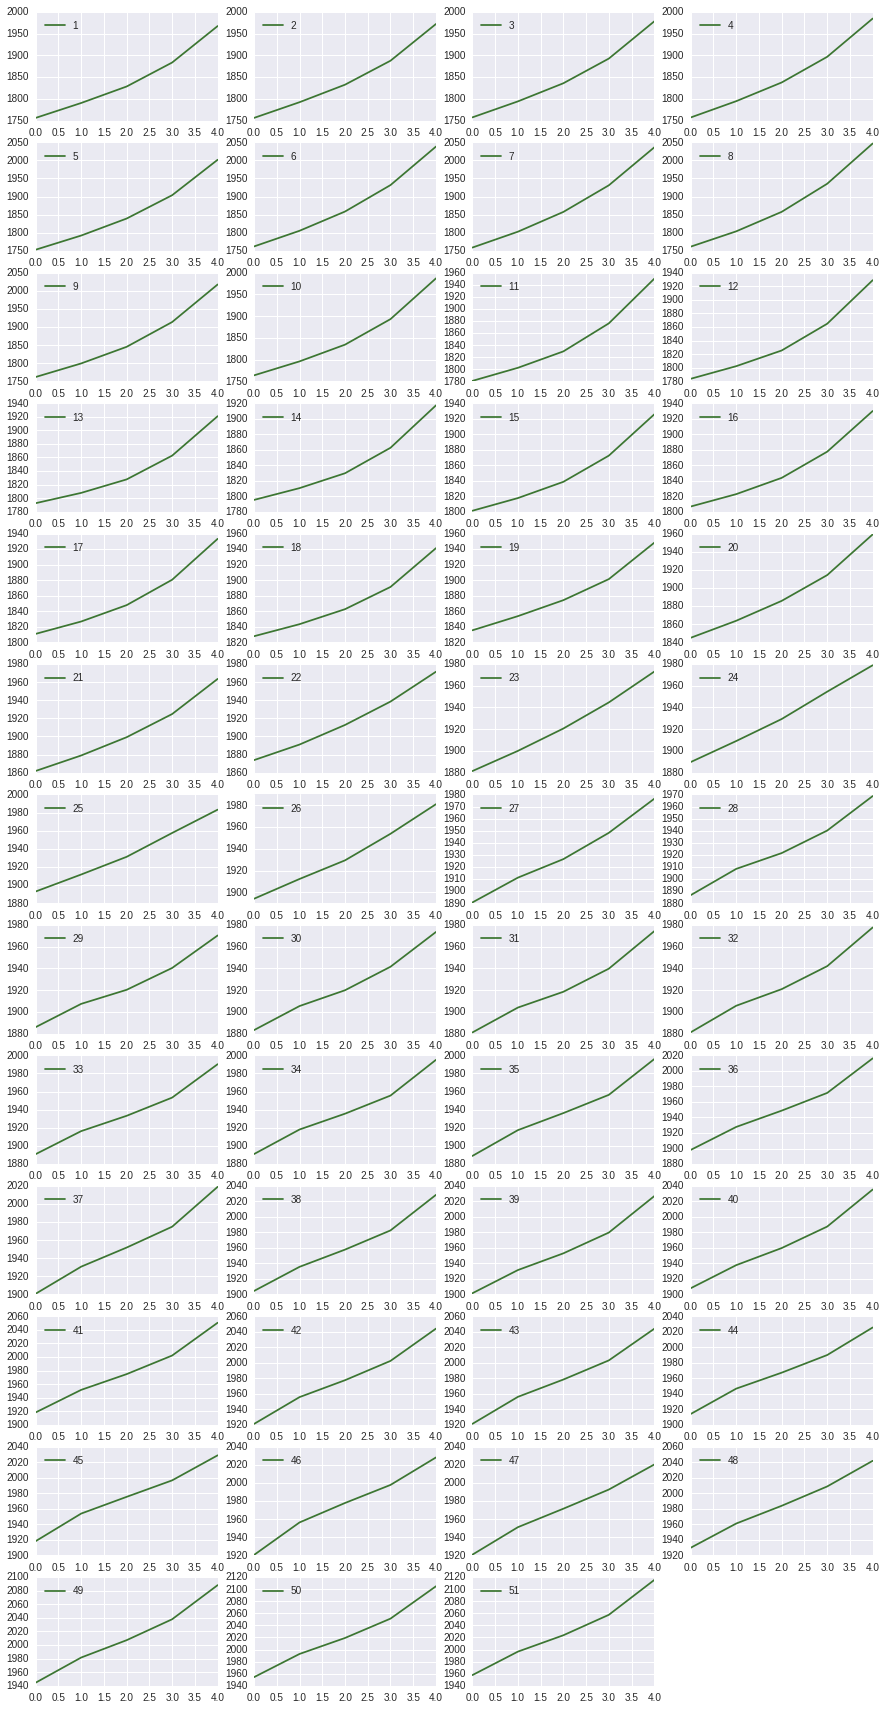

In [78]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    plt.plot(profile_avg[i], label=str(i+1), color=colors[3])
    plt.legend(loc=2)

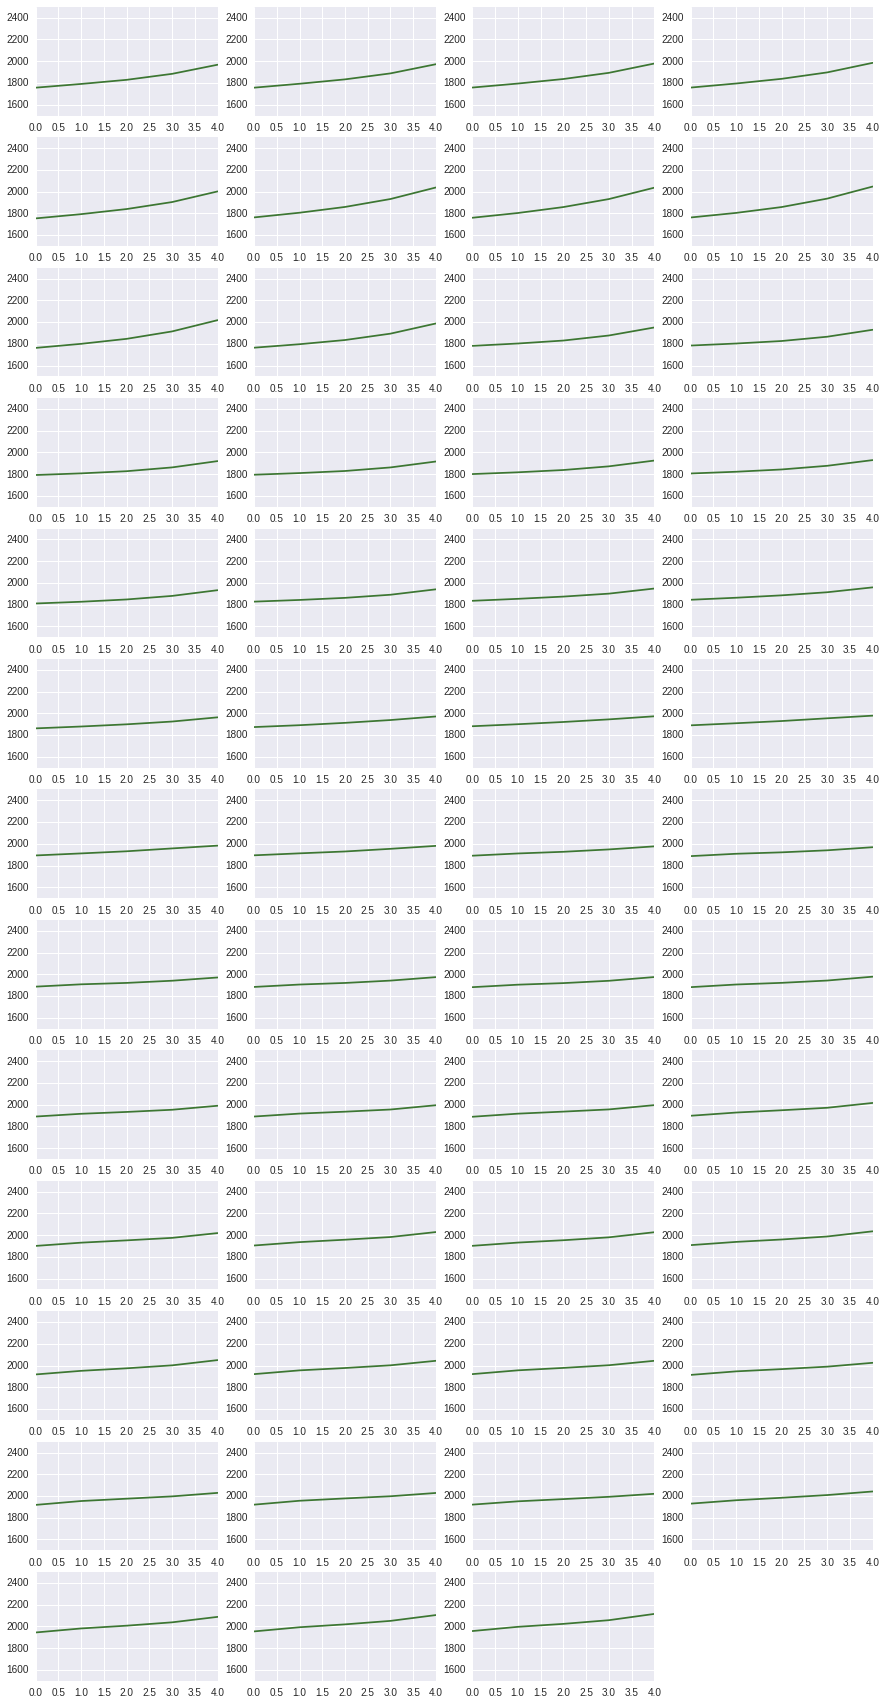

In [83]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    plt.plot(profile_avg[i], label=str(i+1), color=colors[3])
    ax.set_ylim([1500,2500])

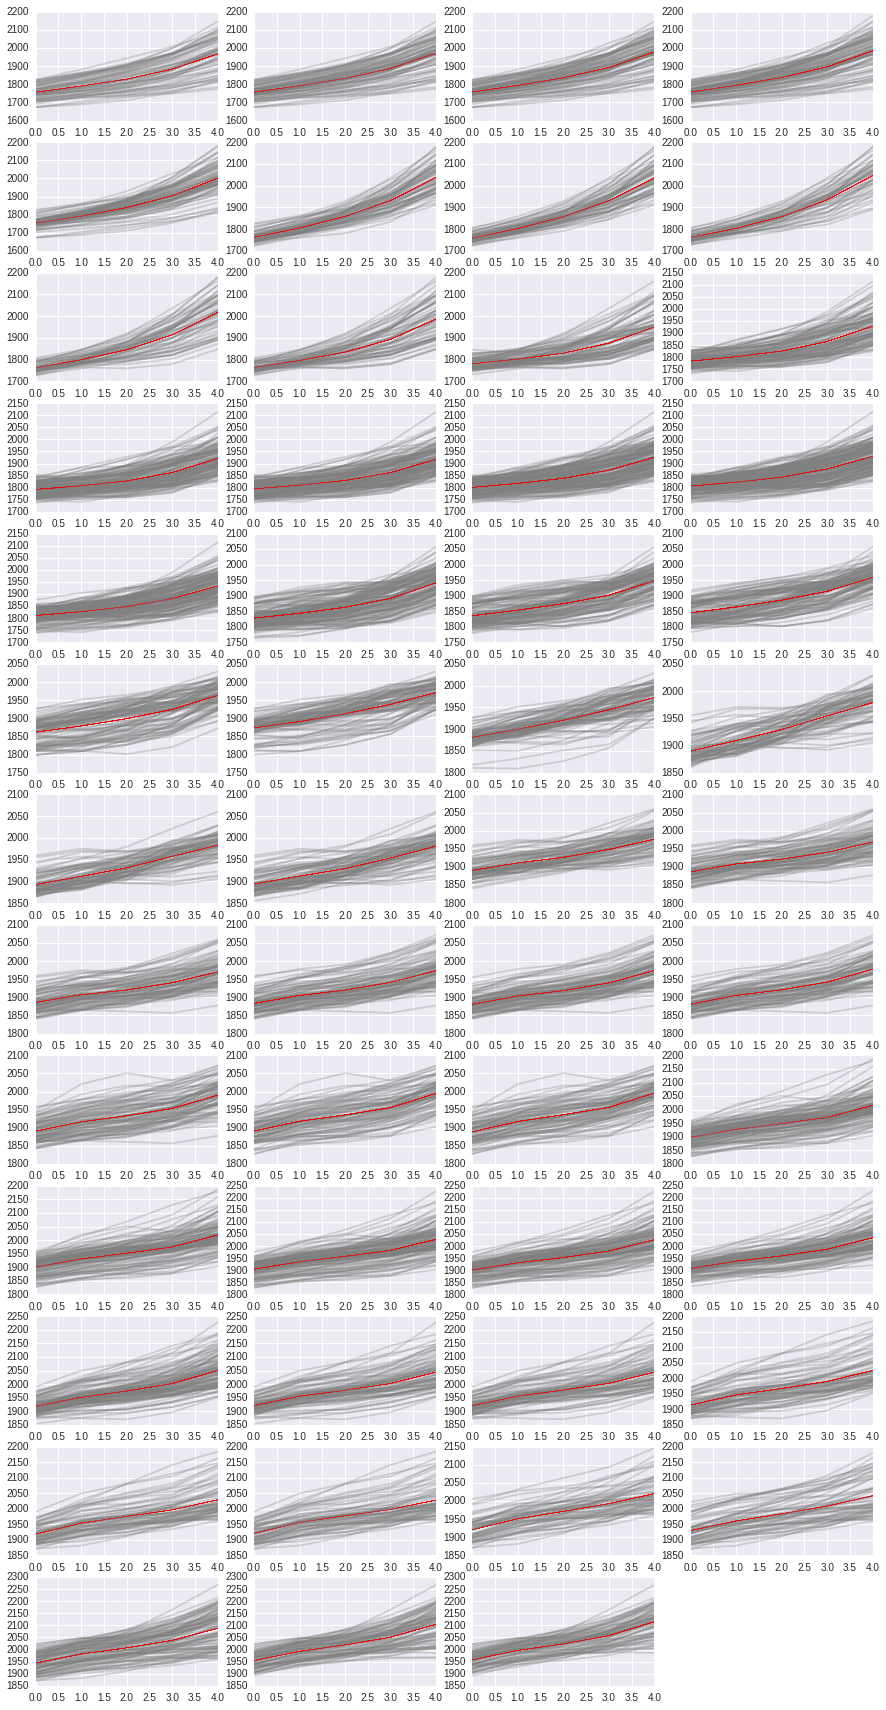

In [84]:
fig = plt.figure(figsize=(15,30))
for i in range(len(profile_avg)):
    ax = fig.add_subplot(int(np.ceil(len(profile_avg)/4)),4,i+1)
    for pro in range(len(profile_windows[i])):
        plt.plot(profile_windows[i][pro],color='gray', alpha=0.3)
        plt.plot(profile_avg[i], color='red', linewidth=0.1)

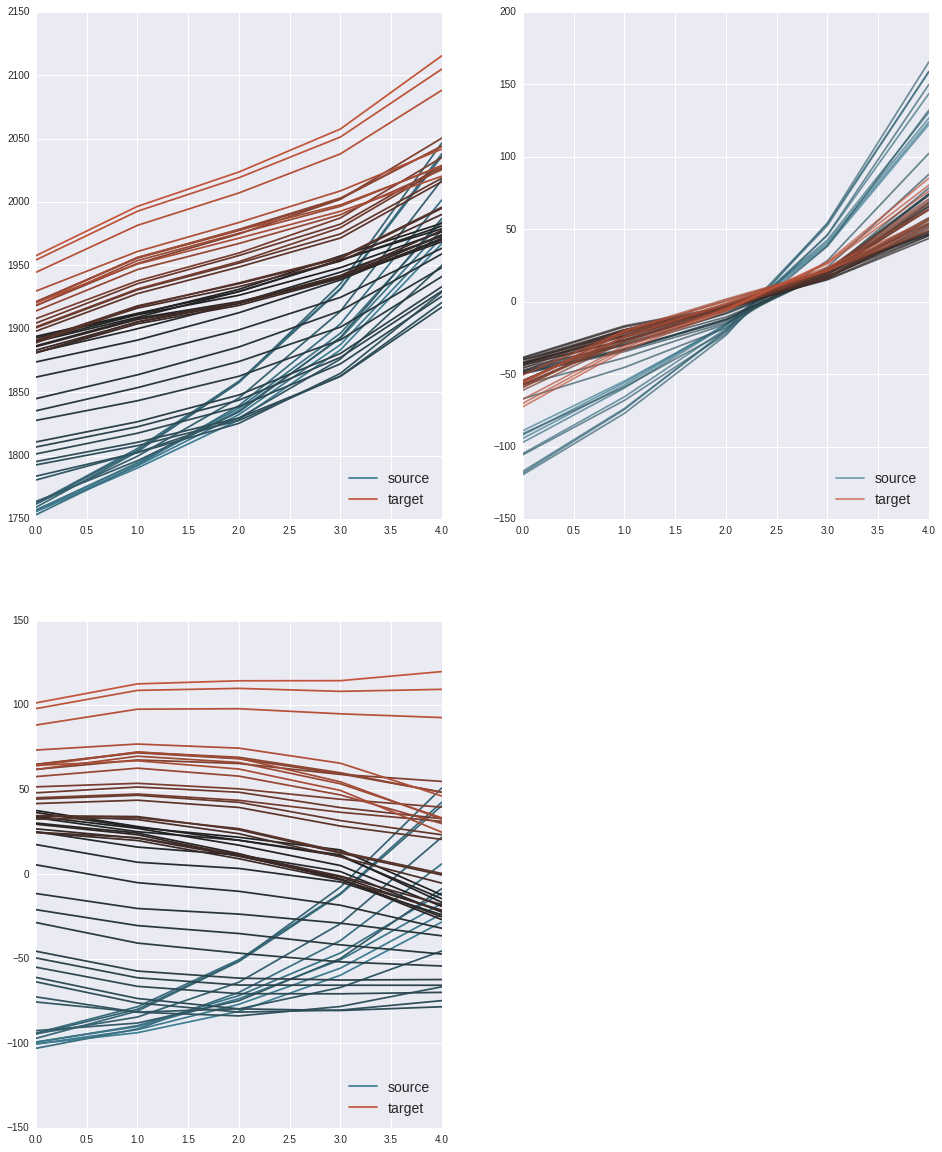

In [85]:
etamap=np.array(sns.diverging_palette(220, 20, n=len(profile_avg), center='dark'))
fig = plt.figure(figsize=(16,20))
fig.add_subplot(221)
for i in range(len(profile_avg)):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(profile_avg[i], color=(r,g,b),label='source')
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i], color=(r,g,b),label='target')
    else:
        plt.plot(profile_avg[i], color=(r,g,b))
plt.legend(loc=4, fontsize=14)


fig.add_subplot(222)
for i in range(len(profile_avg)):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='source', alpha=0.7)
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b),label='target', alpha=0.7)
    else:
        plt.plot(profile_avg[i]-np.mean(profile_avg[i]), color=(r,g,b), alpha=0.7)
plt.legend(loc=4, fontsize=14)


fig.add_subplot(223)
for i in range(len(profile_avg)):
    r=etamap[i][0]
    g=etamap[i][1]
    b=etamap[i][2]
    if i==0:
        plt.plot(profile_avg[i]-np.mean(profile_avg, axis=0), color=(r,g,b),label='source')
    elif i==len(profile_avg)-1:
        plt.plot(profile_avg[i]-np.mean(profile_avg, axis=0), color=(r,g,b),label='target')
    else:
        plt.plot(profile_avg[i]-np.mean(profile_avg, axis=0), color=(r,g,b))
plt.legend(loc=4, fontsize=14)

### euclidian distance between chebychev coefficients

In [ ]:
euclid_list=[]
for w in range(len(combined_windows)-1):
    diff=sp.spatial.distance.euclidean(cheb_coeffs[w],cheb_coeffs[w+1])
    euclid_list.append(diff)

In [ ]:
sns.set_context('notebook', font_scale=1.5)
fig = plt.figure(figsize=(15,10))

euclidplot=fig.add_subplot(2,1,1)
plt.plot(euclid_list)
euclidplot.set_xlim([0, len(windows)])
euclidplot.set_xticks(range(0, len(combined_windows), 2))
sns.axlabel('','euclidian distance \nchebychev coefficients', fontsize=20)

corr=fig.add_subplot(2,1,2)
plt.plot(r_corr_avgs)
corr.set_xlim([0,len(windows)])
corr.set_xticks(range(0, len(combined_windows), 2))
sns.axlabel('','corr', fontsize=20)

In [ ]:
def euclid(coeffs):
    euclid_array=np.zeros((coeffs.shape[0], coeffs.shape[0]))
    for i in range(coeffs.shape[0]):
        for j in range(coeffs.shape[0]):
            euclid_array[i,j]=sp.spatial.distance.euclidean(cheb_coeffs[i],cheb_coeffs[j])
    return euclid_array

In [ ]:
euclid_windows=euclid(cheb_coeffs)